# O problema

Considere o circuito elétrico apresentado na figura abaixo em que PCC representa o ponto de acoplamento comum (do inglês *Point of Common Coupling*). O sinal $u(t)$ representa a tensão de saída de um inversor monofásico.

filtroL.drawio.svg

Considere que


*   A indutância do filtro de saída é $L_c=5$ mH;
*   A indutância da rede é $L_g=1$ mH;
*   A resistência parasita do indutor $L_c$ é $r_c=0,2$ $\Omega$;
*   A resistencia parasita do indutor $L_g$ é $r_g=0,2$ $\Omega$;
*   A tensão da rede é $v_g(t) = 311 \text{sen}(2\pi 60 t + \pi/4)$.

A partir desses parâmetros, projete um controlador adaptativo por modelo de referência (MRAC) em tempo discreto para controlar a corrente $i(t)$ no filtro $L$, considerando um período de amostragem $T = 100$ $\mu$ s e um sinal de referência de corrente $r(t) = 5 \text{sen}(2\pi 60 t)$.



# Modelando o circuito

Utilizando o método das malhas, a soma das tensões na malha única do circuito deve resultar em uma tensão nula. Considerando o sentido de circulação de $i(t)$, tem-se
$$ u(t) - L_c \frac{d i(t)}{dt} - r_c \cdot i(t) -L_g \frac{d i(t)}{dt} - r_g \cdot i(t) - v_g(t) = 0 \tag{1}$$.
Resolvendo (1) em relação a $di(t)/dt$ e substituindo a tensão de rede, tem-se
$$ \frac{d}{dt} i(t) = -\frac{r_c+r_g}{L_c+L_g} i(t) + \frac{u(t)}{L_c+L_g} - \frac{311 \text{sen}\left(2\pi 60 t + \frac{\pi}{4}\right)}{L_c+L_g} \tag{2}$$
em que (2) indica um sistema de primeira ordem com distúrbios senoidas de frequência angular $\omega_0= 2\pi 60$.

# O modelo de sinais
Considerando que o problema pede a determinação dos parâmetros de um MRAC, imagino que o diagrama de blocos equivalente do sistema desejado é semelhante à figura abaixo

filtroLdiagramablocos.drawio (1).svg

Considerando o vetor de entrada
$${\boldsymbol \omega}(t) = [F(r(t)), F(i(t)), V_c(t), V_s(t)] \tag{3}$$
em que $F(.)$ indica a operação de filtragem de um sinal e o vetor de parâmetros do controlador
$${\boldsymbol \theta}(t) = [\theta_{Fr}(t), \theta_{Fi}(t), \theta_{V_c}(t), \theta_{V_s}(t)] \tag{4}$$
utilizaremos a ação de controle
$$u(t) = {\boldsymbol \theta}^\top(t){\boldsymbol \omega}(t) \tag{5}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linear_system import linear_system

In [2]:
omega0 = 2*np.pi*60
Lc = 5E-3
Lg = 1E-3
rc = 0.2
rg = 0.2
Ts = 100E-6
fs = 1.0/Ts

In [3]:
gamma = 200000
plant_b = np.array([1/(Lc+Lg)])
plant_a = np.array([1, (rc+rg)/(Lc+Lg)])
reference_b = np.array([2E4])
reference_a = np.array([1,2E4])
filter_b = np.array([2E4])
filter_a = np.array([1, 2E4])

Wm = linear_system(b=reference_b,
                   a=reference_a, 
                   sampling_rate=fs)
Wm.set_null_state()

Gp = linear_system(b=plant_b,
                   a=plant_a, 
                   sampling_rate=fs)
Gp.set_null_state()

Gpvg = linear_system(b=plant_b,
                     a=plant_a, 
                     sampling_rate=fs)
Gpvg.set_null_state()

Fy = linear_system(b=filter_b,
                   a=filter_a, 
                   sampling_rate=fs)
Fy.set_null_state()

Fr = linear_system(b=filter_b,
                   a=filter_a, 
                   sampling_rate=fs)
Fr.set_null_state()

rho = (plant_b[-1]/plant_a[-1])/(reference_b[-1]/reference_a[-1])

In [4]:
t_start = 0
t_end = 0.2

t_sim = np.arange(t_start, t_end, Ts)

In [5]:
r = 5*np.sin(omega0*t_sim)
phi = np.pi/4
Ag = 311.0
vg = Ag*np.sin(omega0*t_sim+phi)
y = 0
filtered_r = 0
filtered_y = 0

In [6]:
N_states = 4
theta = np.zeros(N_states)

output_signal = np.zeros(len(t_sim))
states_history = np.zeros((N_states,len(t_sim)))

# reference signal
ym,_  = Wm.simulate_zoh(r, np.zeros(len(reference_a)-1))

for i in range(len(t_sim)):
    # Controler
    omega = np.array([filtered_r, filtered_y, np.cos(omega0*t_sim[i]), np.sin(omega0*t_sim[i])])
    states_history[:,i] = theta
    u = omega@theta

    # Unknown plant 
    y = Gp.iterate_zoh(u) - Gp.iterate_zoh(vg[i])
    output_signal[i] = y

    # Filtered states
    filtered_u = Fr.iterate_zoh(u)
    filtered_y = Fy.iterate_zoh(y)
    #estimation error
    error = y - ym[i]
    # Controler Parameters update
    m2 = 1+omega@omega
    theta = theta - gamma * omega * error * np.sign(rho)/(m2*fs)

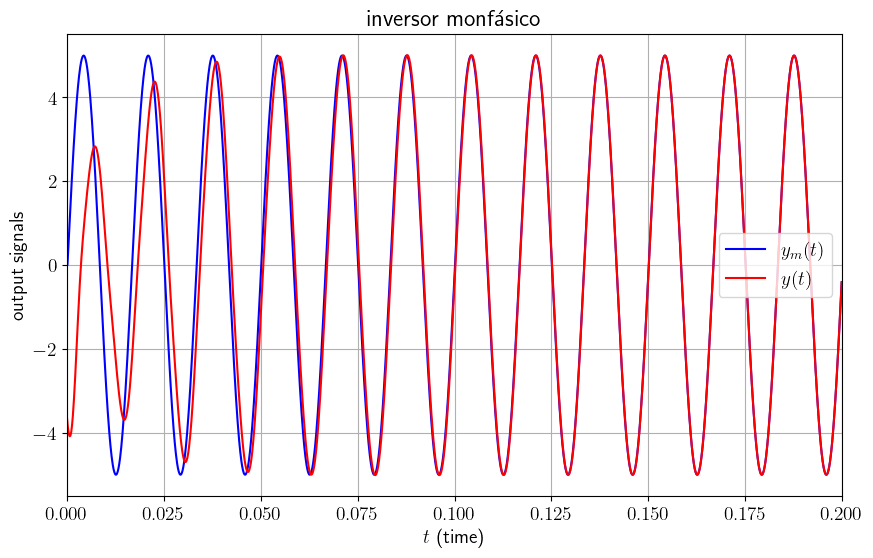

In [7]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))
plt.plot(t_sim, ym, 'b', label=r'$y_m(t)$')
plt.plot(t_sim, output_signal, 'r', label=r'$y(t)$')
plt.legend(loc='best')
#plt.plot([t_init, t_end], [bm/bp,bm/bp],'b:')
#plt.plot([t_init, t_end], [(am-ap)/bp,(am-ap)/bp],'r:')
plt.xlabel(r'$t$ (time)')
plt.ylabel(r'output signals')
plt.title(r'inversor monfásico')
plt.grid(True,'both')
plt.xlim([t_start, t_end])
#plt.ylim([-5,5])
plt.show()

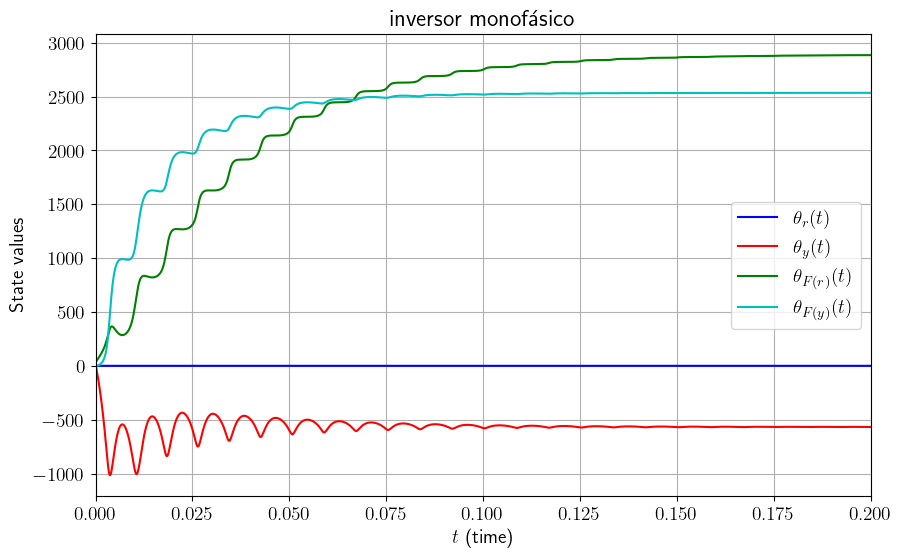

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t_sim, states_history[0,:], 'b', label=r'$\theta_r(t)$')
plt.plot(t_sim, states_history[1,:], 'r', label=r'$\theta_y(t)$')
plt.plot(t_sim, states_history[2,:], 'g', label=r'$\theta_{F(r)}(t)$')
plt.plot(t_sim, states_history[3,:], 'c', label=r'$\theta_{F(y)}(t)$')
plt.legend(loc='best')
#plt.plot([t_init, t_end], [bm/bp,bm/bp],'b:')
#plt.plot([t_init, t_end], [(am-ap)/bp,(am-ap)/bp],'r:')
plt.xlabel(r'$t$ (time)')
plt.ylabel(r'State values')
plt.title(r'inversor monofásico')
plt.grid(True,'both')
plt.xlim([t_start, t_end])
plt.show()